In [224]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial, lru_cache
from scipy import integrate
import plotly.graph_objects as go
from tqdm import tqdm
import scipy.interpolate
import pandas as pd


## Normal Inverse Gaussian Distribution
$$
f_{\text{NIG}} = \frac{\delta \alpha \cdot \exp\{\delta \gamma + \beta (x-\mu)\}}{\pi \cdot \sqrt{\delta^2 + (x-\mu)^2}}
K_1 \{\alpha \sqrt{\delta^2 + (x-\mu)^2}\}
$$

where $\mu$ is location parameter (mean), $\delta>0$ is scale parameter (standard deviation), $\gamma= \sqrt{\alpha^2 - \beta^2}$, $\alpha$ is tail heaviness, and $\beta$ is asymmetry paramter satisfying $0\leq |\beta| \leq \alpha$.




/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



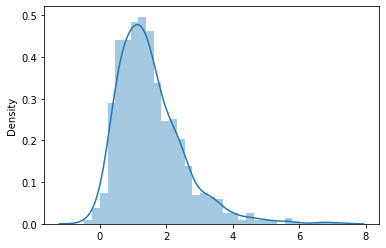

In [225]:
alpha = 6
beta = 5
loc = 0
scale = 1

size = 1000

rho = 0.9

M = stats.norminvgauss(a=alpha, b=beta, loc=loc, scale=scale).rvs(size)

sns.distplot(M)

## Normal Inverse Gaussian Copula

$X_i = \rho M + \sqrt{1-\rho^2} \varepsilon_i$

$\rho M \sim \text{NIG}\left(
\frac{\alpha_1}{\rho}, 
\frac{\beta_1}{\rho},
\rho \mu_1, 
\rho \delta_1
\right)$


$\sqrt{1-\rho^2} \varepsilon_i \sim \text{NIG}\left( 
\frac{\alpha_2}{\sqrt{1-\rho^2}}, 
\frac{\beta_2}{\sqrt{1-\rho^2}},
\sqrt{1-\rho^2} \mu_2, 
\sqrt{1-\rho^2} \delta_2
\right)$


For simplicity we set
$$
\alpha_1=\alpha_2=\alpha
$$

$$
\beta_1=\beta_2=\beta
$$

$$ \gamma = \sqrt{\alpha^2 - \beta^2}$$

Normalise $X_i$ to zero mean and unit variance we set
$$\mu_1=-\frac{\beta \gamma^2}{\alpha^2}$$
$$\mu_2=-\frac{\sqrt{1-\rho^2}}{\rho} \frac{\beta \gamma^2}{\alpha^2}$$

$$\delta_1=\frac{\gamma^3}{\alpha^2}$$
$$\delta_2=\frac{\sqrt{1-\rho^2}}{\rho}\frac{\gamma^3}{\alpha^2}$$


$X_i \sim \text{NIG} \sim \left(
\frac{\alpha}{\rho},
\frac{\beta}{\rho}, 
\frac{\beta \gamma^2}{\rho \alpha^2},
\frac{\gamma^3}{\rho \alpha^2}
\right)$


Text(0.5, 1.0, 'Sample of Normal Inverse Gaussian Copula $rho=0.90$')

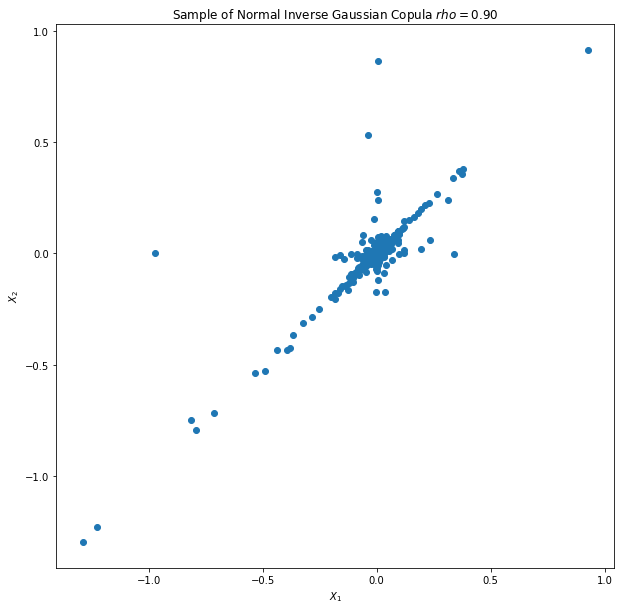

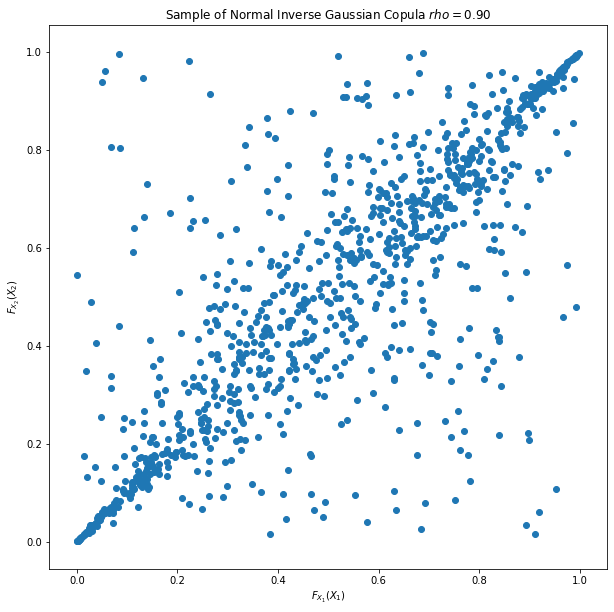

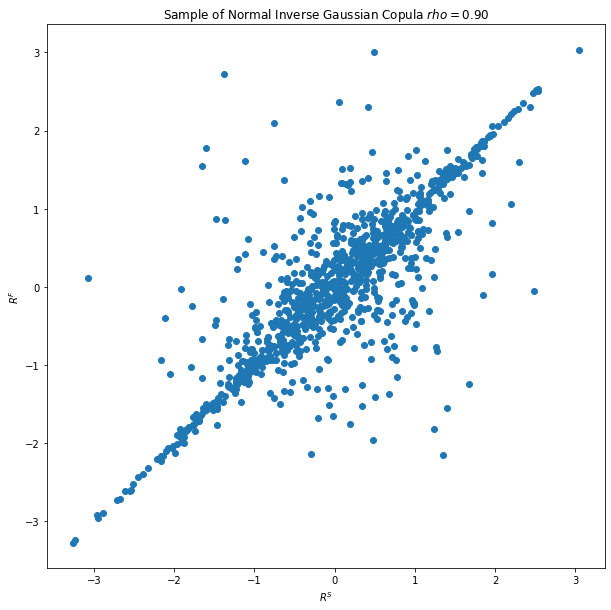

In [352]:
rho    = 0.9
ratio  = np.sqrt(1-rho**2)/rho

alpha  = 0.01
beta   = 0
gamma  = np.sqrt(alpha**2-beta**2)
loc    = 0
scale  = 1
mu1    = -(beta*gamma**2)/(alpha**2)
mu2    = mu1 * ratio
delta1 = (gamma**3)/(alpha**2)
delta2 = delta1 * ratio

size   = 1000

# Laws
M_law  = stats.norminvgauss(a=alpha, b=beta, loc=mu1, scale=delta1)
epsilon1_law = stats.norminvgauss(a=ratio*alpha, b=ratio*beta, loc=mu2, scale=delta2)
epsilon2_law = stats.norminvgauss(a=ratio*alpha, b=ratio*beta, loc=mu2, scale=delta2)
X1_law = stats.norminvgauss(a=alpha/rho, b=beta/rho, loc=mu1/rho, scale=delta1/rho)
X2_law = stats.norminvgauss(a=alpha/rho, b=beta/rho, loc=mu1/rho, scale=delta1/rho)

# RVs
M        = M_law.rvs(size=size)
epsilon1 = epsilon1_law.rvs(size)
epsilon2 = epsilon2_law.rvs(size)
X1       = rho*M + np.sqrt(1-rho**2)*epsilon1
X2       = rho*M + np.sqrt(1-rho**2)*epsilon2

plt.figure(figsize=(10,10))
# sns.kdeplot(x=X1, y=X2)
plt.scatter(X1, X2)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title(r"Sample of Normal Inverse Gaussian Copula $rho=%.2f$"%rho)


plt.figure(figsize=(10,10))
# sns.kdeplot(x=X1, y=X2)
plt.scatter(X1_law.cdf(X1), X2_law.cdf(X2))
plt.xlabel(r"$F_{X_1}(X_1)$")
plt.ylabel(r"$F_{X_2}(X_2)$")
plt.title(r"Sample of Normal Inverse Gaussian Copula $rho=%.2f$"%rho)

plt.figure(figsize=(10,10))
# sns.kdeplot(x=X1, y=X2)
plt.scatter(RS_law.ppf(X1_law.cdf(X1)), RF_law.ppf(X2_law.cdf(X2)))
plt.xlabel(r"$R^S$")
plt.ylabel(r"$R^F$")
plt.title(r"Sample of Normal Inverse Gaussian Copula $rho=%.2f$"%rho)

In [227]:
M_law.pdf(0.1)

0.13067567894905965

In [228]:
RS_law = stats.norm
RF_law = stats.norm
rs=-0.02
rf=0.01

part1 = lambda m: epsilon1_law.cdf( (X1_law.ppf(RS_law.cdf(rs))-rho*m)/(np.sqrt(1-rho**2)) )
part2 = lambda m: epsilon2_law.cdf( (X2_law.ppf(RS_law.cdf(rf))-rho*m)/(np.sqrt(1-rho**2)) )
fn = lambda m: part1(m)*part2(m)*M_law.pdf(m)
integrate.quad(fn, -np.infty, np.infty)

(0.3482971310386385, 6.671216819470558e-09)

In [229]:
RS = RS_law.ppf(X1_law.cdf(X1))
RF = RF_law.ppf(X2_law.cdf(X2))

In [230]:
np.mean((RS_law.cdf(RS)<=.1) & (RF_law.cdf(RF)<=.1))

0.019

In [231]:
%%time
def C(u,v):
    part1 = lambda m: epsilon1_law.cdf( (X1_law.ppf(u)-rho*m)/(np.sqrt(1-rho**2)) )
    part2 = lambda m: epsilon2_law.cdf( (X2_law.ppf(v)-rho*m)/(np.sqrt(1-rho**2)) )
    fn    = lambda m: part1(m)*part2(m)*M_law.pdf(m)
    return integrate.quad(fn, -np.infty, np.infty)[0]

def D1C(u,v):
    part1 = lambda m: epsilon1_law.pdf((X1_law.ppf(u)-rho*m)/np.sqrt(1-rho**2))
    part2 = 1/X1_law.pdf(X1_law.ppf(u))
    part3 = lambda m: epsilon2_law.pdf((X2_law.ppf(v)-rho*m)/np.sqrt(1-rho**2))
    part4 = lambda m: M_law.pdf(m)
    fn    = lambda m: part1(m)*part3(m)*part4(m)
    return integrate.quad(fn, -np.infty, np.infty)[0]*part2

def F_RH(rh, h):
    fn = lambda w: D1C(w, RF_law.cdf((RS_law.ppf(w)-rh)/h))
    return 1- integrate.quad(fn, 0.0001, 0.999)[0]

# D1C(0.5,0.98)
# F_RH(rh=0.0,h=1)
C(.1,.1)

CPU times: user 10.9 s, sys: 74.2 ms, total: 10.9 s
Wall time: 11 s


0.022696474604191594

In [232]:
def c(u,v):
    part0 = 1/( X1_law.pdf(X1_law.ppf(u))*X2_law.pdf(X2_law.ppf(v)) )
    part1 = lambda m: epsilon1_law.pdf( (X1_law.ppf(u)-rho*m)/(np.sqrt(1-rho**2)) )
    part2 = lambda m: epsilon2_law.pdf( (X2_law.ppf(v)-rho*m)/(np.sqrt(1-rho**2)) )
    fn = lambda m: part1(m)*part2(m)*M_law.pdf(m)
    return part0 * integrate.quad(fn, -np.infty, np.infty)[0]

def c_parallel(a):
    u,v = a
#     result.value = c(u,v)
    return c(u,v)
    
def f_RH(h, rh):
    fn = lambda w: c(w, RF_law.cdf((RS_law.ppf(w)-rh)/h)) * RF_law.pdf((RS_law.ppf(w)-rh)/h)
    return np.abs(1/h) * integrate.quad(fn, 0.0001, 0.999)[0]
    

In [125]:
import multiprocessing

A = [(0.1, 0.1),(0.2, 0.2),(0.3,0.3),(0.4,0.4)]

p = Pool(processes=4)
data = p.map(c_parallel, A)
p.close()

KeyboardInterrupt: 

In [124]:
c_parallel(A[1])

0.8366751844552097

In [119]:
def a_function(ret_value):
    ret_value.value = 3.145678

ret_value = multiprocessing.Value("d", 0.0, lock=False)
reader_process = multiprocessing.Process(target=a_function, args=[ret_value])
reader_process.start()
reader_process.join()

print(ret_value.value)

0.0


In [234]:
# f_RS RF
@lru_cache(None)
def f_RSRF(rs, rf):
    part1 = lambda rs: RS_law.pdf(rs)/X1_law.pdf(X1_law.ppf(RS_law.cdf(rs)))
    part2 = lambda rf: RF_law.pdf(rf)/X2_law.pdf(X2_law.ppf(RF_law.cdf(rf)))

    part3_fn = lambda v, rs: epsilon1_law.pdf( (X1_law.ppf(RS_law.cdf(rs)) - np.sqrt(rho)*M_law.ppf(v))/np.sqrt(1-rho))
    part4_fn = lambda v, rf: epsilon2_law.pdf( (X2_law.ppf(RF_law.cdf(rf)) - np.sqrt(rho)*M_law.ppf(v))/np.sqrt(1-rho))

    part3_toint = partial(part3_fn, rs=rs)
    part4_toint = partial(part4_fn, rf=rf)

    part34 = lambda v: part3_toint(v)*part4_toint(v)/M_law.pdf(v)
    return part1(rs) * part2(rf) * integrate.quad(part34, 0,1)[0]

def c(u,v):
    return f_RSRF(RS_law.ppf(u), RF_law.ppf(v))/( RS_law.pdf(RS_law.ppf(u))*RF_law.pdf(RF_law.ppf(v)) )

In [235]:
rs_arr = np.linspace(-2,2,12)
rf_arr = np.linspace(-2,2,12)

grids = np.array(np.meshgrid(rs_arr, rf_arr)).T.reshape(-1,2)
len(grids)

144

In [200]:


results = []
for g in tqdm(grids):
    results.append(f_RSRF(g[0], g[1]))
       
# results_c = []
# for g in tqdm(grids):
#     results_c.append(c(RS_law.cdf(g[0]), RF_law.cdf(g[1])))

100%|██████████| 144/144 [22:15<00:00,  9.27s/it]


In [339]:
Z

array([[3.38201022e-02, 3.57610700e-02, 3.74784886e-02, ...,
        2.24523662e-08, 1.70209166e-08, 1.25676800e-08],
       [3.57610700e-02, 3.79076799e-02, 3.98375161e-02, ...,
        2.83926556e-08, 2.21618861e-08, 1.70911081e-08],
       [3.74784886e-02, 3.98375161e-02, 4.19921655e-02, ...,
        3.57402691e-08, 2.84750532e-08, 2.26032643e-08],
       ...,
       [2.24523662e-08, 2.83926556e-08, 3.57402691e-08, ...,
        4.43962817e-02, 4.21217261e-02, 3.96303631e-02],
       [1.70209166e-08, 2.21618861e-08, 2.84750532e-08, ...,
        4.21217261e-02, 4.00843668e-02, 3.78171482e-02],
       [1.25676800e-08, 1.70911081e-08, 2.26032643e-08, ...,
        3.96303631e-02, 3.78171482e-02, 3.57669629e-02]])

In [338]:
spline = scipy.interpolate.Rbf(grids[:,0],grids[:,1],results,
                               function='gaussian',
                               smooth=0, episilon=0)

B1, B2 = np.meshgrid(np.linspace(-2,2,120), np.linspace(-2,2,120), indexing='xy')
Z = spline(B1, B2)
fig = go.Figure(data =
    go.Surface(
        z=Z.reshape(120,120),
        x=np.linspace(-2,2,120), # horizontal axis
        y=np.linspace(-2,2,120) # vertical axis
    ))
fig.show()

In [334]:
fig = go.Figure(data =
    go.Surface(
        z=(Z/(RS_law.pdf(B1)*RF_law.pdf(B2))).reshape(120,120),
        x=RS_law.cdf(B1), # horizontal axis
        y=RF_law.cdf(B2) # vertical axis
    ))
fig.show()

In [204]:
fig = go.Figure(data =
    go.Surface(
        z=np.array(results).reshape(12,12),
        x=rs_arr, # horizontal axis
        y=rf_arr # vertical axis
    ))
fig.show()

In [205]:
fig = go.Figure(data =
    go.Surface(
        z=(np.array(results)/(RS_law.pdf(grids[:,0])*RF_law.pdf(grids[:,1]))).reshape(12,12),
        x=RS_law.cdf(rs_arr), # horizontal axis
        y=RF_law.cdf(rf_arr) # vertical axis
    ))
fig.show()

In [220]:
fig = go.Figure(data =
    go.Contour(
        z=results,
        x=grids[:,0], # horizontal axis
        y=grids[:,1] # vertical axis
    ))
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20))
fig.show()

In [222]:
fig = go.Figure(data =
    go.Contour(
        z=np.array(results)/(RS_law.pdf(grids[:,0])*RF_law.pdf(grids[:,1])),
        x=RS_law.cdf(grids[:,0]), # horizontal axis
        y=RF_law.cdf(grids[:,1]) # vertical axis
    ))
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20))
fig.show()

In [237]:
%%time
rs=2
rf=-1.99

f_RSRF(rs, rf)

CPU times: user 1.86 s, sys: 24.1 ms, total: 1.88 s
Wall time: 1.88 s


1.3493404164091468e-08

In [182]:
spline(rs, rf) 

array(2.27620056e-10)

In [325]:
# Parameter Estimation
rs_arr = stats.norm.rvs(size=1500)
rf_arr = stats.norm.rvs(size=1500)

A = X1_law.ppf(RS_law.cdf(rs_arr))
B = X2_law.ppf(RF_law.cdf(rs_arr))

n_int = 1000
V = np.linspace(0,1,n_int)
M = M_law.ppf(V)
S = []

In [326]:
rho_arr = [0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
l = []

for rho in rho_arr:
    
    S = []
    for i in range(len(A)):
        toint = epsilon1_law.pdf( (A[i]-np.sqrt(rho)*M)/np.sqrt(1-rho)) * epsilon2_law.pdf( (B[i]-np.sqrt(rho)*M)/np.sqrt(1-rho)) 
        S.append(np.log(np.sum((toint[:-1]+toint[1:])*(1/n_int)/2)))
    l.append(np.sum(S))

In [327]:
pd.DataFrame(dict(keys=rho_arr, value=l))

,keys,value
0,0.001,-4187.517103
1,0.100,-4331.637625
2,0.200,-4497.955068
3,0.300,-4688.543970
4,0.400,-4906.713452
5,0.500,-5155.650187
6,0.600,-5442.635397
7,0.700,-5792.608169
8,0.800,-6271.987885
9,0.900,-7076.243514


In [332]:
u = RS_law.cdf(rs_arr)

In [353]:
rho_arr = [0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
l = []

for rho in rho_arr:
    S = []
    for i in range(len(A)):
        toint = epsilon1_law.pdf( (A[i]-np.sqrt(rho)*M)/np.sqrt(1-rho)) * epsilon2_law.pdf( (B[i]-np.sqrt(rho)*M)/np.sqrt(1-rho)) 
        S.append(np.log(np.sum((toint[:-1]+toint[1:])*(1/n_int)/2)))
    l.append(np.sum(S))

In [354]:
pd.DataFrame(dict(keys=rho_arr, value=l))

,keys,value
0,0.001,-15886.862309
1,0.100,-13720.796929
2,0.200,-12821.369755
3,0.300,-12172.503562
4,0.400,-11998.576497
5,0.500,-12165.450968
6,0.600,-12217.509147
7,0.700,-12545.412739
8,0.800,-13557.617548
9,0.900,-15209.459305


Amazing paper about tail dependence:
https://www.sciencedirect.com/science/article/pii/S0047259X15000160